In [1]:
# Must be included at the beginning of each notebook. Remember to change the app name. 
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark

# Create SparkSession and giving it an appname
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('data_preparation').getOrCreate()

import warnings
warnings.simplefilter(action='ignore')

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/10/12 23:03:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Import the relevant Python libraries.
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import regexp_replace, udf
from pyspark.sql.types import IntegerType
from pyspark.sql.types import *
from pyspark.sql.functions import *
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, Bucketizer 
import seaborn as sns
import pandas as pd
from pyspark.sql import Window

from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
import json
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [3]:
# Use Spark to read in the Maternal Health csv file; you can infer csv schemas.
data = spark.read.csv("Maternal Health Risk Data Set.csv", inferSchema=True, header=True)
data.show(5, truncate=15)

+---+----------+-----------+----------+--------+---------+---------+----------+
|Age|SystolicBP|DiastolicBP|bloodsugar|bodyTemp|heartRate|riskLevel|   comment|
+---+----------+-----------+----------+--------+---------+---------+----------+
| 25|       130|         80|      15.0|    98.0|       86|high risk|no comment|
| 35|       140|         90|      13.0|    98.0|       70|high risk|no comment|
| 29|        90|         70|       8.0|   100.0|       80|high risk|no comment|
| 30|       140|         85|       7.0|    98.0|       70|high risk|no comment|
| 35|       120|         60|       6.1|    98.0|       76| low risk|no comment|
+---+----------+-----------+----------+--------+---------+---------+----------+
only showing top 5 rows



In [4]:
def data_prep(data):
    #######3.1
    data.filter((data['Age']==-9999999) | (data['Age']==1000) | (data['heartRate']==7))
    # drop the 'comment' column    
    data=data.drop('comment')
    #######3.2.1
    # delete row containing '" "'
    data=data.filter(data.riskLevel!=" ")
    # delete extreme 'Age' value rows
    data = data.filter(data.Age!=-9999999)
    data = data.filter(data.Age!=-1)
    data = data.filter(data.Age!=1000)
    #Replace part of string with another string
    data = data.withColumn('Age', regexp_replace('Age', '-23', '23'))
    # Type cast string column to integer column in pyspark
    data = data.withColumn("Age", data["Age"].cast(IntegerType()))
    # find average 'Age'
    data.agg({'Age': 'avg'})
    # exclude extreme 'heartRate' values
    data = data.filter(data.heartRate!=7)
    ##########3.2.2 Convert data types
    # Type cast in pyspark
    data=data.withColumn('Age', data['Age'].cast(DoubleType()))
    data=data.withColumn('SystolicBP', data['SystolicBP'].cast(DoubleType()))
    data = data.withColumn("DiastolicBP", data["DiastolicBP"].cast(DoubleType()))
    ##########3.2.3 'riskLevel' coding scheme
    # reclassify into "low risk" class
    f=data.where(data.riskLevel.startswith('L'))
    for i in range(0,f.count()):
        data=data.withColumn('riskLevel', F.regexp_replace('riskLevel', f.collect()[i]['riskLevel'], "low risk"))
    # reclassify into "mid risk" class
    f=data.where(data.riskLevel.startswith('M'))
    for i in range(0, f.count()):
        data=data.withColumn('riskLevel',
                     F.regexp_replace('riskLevel', f.collect()[i]['riskLevel'], 'mid risk'))
    # reclassify into "high risk" class
    f=data.where(data.riskLevel.startswith('H'))
    for i in range(0,f.count()):
        data=data.withColumn('riskLevel',
                     F.regexp_replace('riskLevel', f.collect()[i]['riskLevel'], 'high risk'))
    # Remove leading space of the column in pyspark
    data=data.withColumn('riskLevel', F.trim(data.riskLevel))
    ########3.2.4 Assign integer values to categorical variables
    indexer = StringIndexer(inputCol="riskLevel", outputCol="riskLevelIndex")
    data = indexer.fit(data).transform(data)
    ########3.2.5 Consistency in Attribute naming
    data=data.withColumnRenamed('bloodsugar', 'BS').withColumnRenamed('bodyTemp', 'BodyTemp')
    data=data.withColumnRenamed('heartRate', 'HeartRate').withColumnRenamed('riskLevel', 'RiskLevel')
    data=data.withColumnRenamed('riskLevelIndex', 'RiskLevelIndex')
    ########3.2.6 selecting the target and input variables
    assembler = VectorAssembler(
        inputCols=['Age','SystolicBP','DiastolicBP','BS','BodyTemp','HeartRate'],
        outputCol="features")
    data=assembler.transform(data)
    # target variable
    target=data.select(['RiskLevelIndex']).toPandas()
    ########3.2.7 standardizing the input attribute values
    standardScaler=StandardScaler()
    standardScaler.setInputCol('features')
    model=standardScaler.fit(data)
    model.setOutputCol('features_scaled')
    data=model.transform(data)
    #######3.3 constructing / deriving a new feature
    bucketizer = Bucketizer(splits=[ float('-inf'), 31.5, 45, float('Inf') ],
                            inputCol='Age', outputCol="Age_Tier")
    df_buck = bucketizer.setHandleInvalid("keep").transform(data)
    t = {0.0:"Young", 1.0: "Matured_Young", 2.0:"Middle_Age"}
    udf_foo = udf(lambda x: t[x], StringType())
    df_buck=df_buck.withColumn("Age_Tier", udf_foo("Age_Tier"))
    
    return data

# Use Spark to read in the Maternal Health csv file; you can infer csv schemas.
data = spark.read.csv("Maternal Health Risk Data Set.csv", inferSchema=True, header=True)
data = data_prep(data=data)

In [5]:
# 8.1 Pattern1

In [6]:
# calculate performance accuracy on all the features
data_changed=data.select(data.columns[0:8])
# collect the input features
assembler = VectorAssembler(
        inputCols=['Age','SystolicBP','DiastolicBP','BS','BodyTemp','HeartRate'], outputCol="features")
# transform the data
data_changed=assembler.transform(data_changed)
# standardize the feature values
standardScaler=StandardScaler()
standardScaler.setInputCol('features')
model=standardScaler.fit(data_changed)
model.setOutputCol('features_scaled')
data_changed=model.transform(data_changed)

In [7]:
# splitting data into training and test data set
train_data, test_data = data_changed.randomSplit(weights=[0.75,0.25], seed=1)
# definition to evaluate train accuracy, test accuracy
def testparams(**params):
    rfc = RandomForestClassifier(labelCol='RiskLevelIndex',featuresCol='features_scaled', seed=4, **params)
    model = rfc.fit(train_data)
    def model_score(evaluate_data):
        predictions=model.transform(evaluate_data)
        evaluator = MulticlassClassificationEvaluator(
            labelCol="RiskLevelIndex", predictionCol="prediction", metricName="accuracy")
        return evaluator.evaluate(predictions)
    return model_score(train_data), model_score(test_data)

In [8]:
# definition to evaluate train accuracy, test accuracy
def testparams(**params):
    rfc = RandomForestClassifier(labelCol='RiskLevelIndex',featuresCol='features_scaled', seed=4, **params)
    model = rfc.fit(train_data)
    def model_score(evaluate_data):
        predictions=model.transform(evaluate_data)
        evaluator = MulticlassClassificationEvaluator(
            labelCol="RiskLevelIndex", predictionCol="prediction", metricName="accuracy")
        return evaluator.evaluate(predictions)
    return model_score(train_data), model_score(test_data)

In [9]:
# testparams print train error (left), test error (right)
print('train error (left), test error (right)\n', testparams())
# fit model on train_data
rfc = RandomForestClassifier(labelCol='RiskLevelIndex',featuresCol='features_scaled', seed=4,
                            numTrees=20, maxDepth=10, maxBins=17, subsamplingRate=0.97)
model = rfc.fit(train_data)
# predict response
predictions = model.transform(test_data)
# Metrics
predictionRDD = predictions.select(['RiskLevelIndex', 'prediction']).rdd.map(lambda line: (line[1], line[0]))
metrics = MulticlassMetrics(predictionRDD)
# Confusion Matrix
print('\n Confusion Matrix \n', metrics.confusionMatrix().toArray())

train error (left), test error (right)
 (0.7763659466327827, 0.6844444444444444)



 Confusion Matrix 
 [[75. 17.  1.]
 [16. 47.  4.]
 [ 4.  6. 55.]]


In [10]:
# 8.1 Pattern2

In [11]:
# concatenate the columns to calculate correlation coefficients
data_corr=data_changed.select(data_changed.columns[0:6] + [data_changed.columns[-3]]).toPandas()
# correlation
corr_mat=data_corr.corr()
# view the correlation values
corr_mat['RiskLevelIndex']

Age               0.263775
SystolicBP        0.396500
DiastolicBP       0.346536
BS                0.569161
BodyTemp          0.165693
HeartRate         0.188532
RiskLevelIndex    1.000000
Name: RiskLevelIndex, dtype: float64

In [12]:
# correlation in between features 'BodyTemp' and 'RiskLevel'
data_changed['BodyTemp', 'RiskLevelIndex'].toPandas().corr()

,BodyTemp,RiskLevelIndex
BodyTemp,1.000000,0.165693
RiskLevelIndex,0.165693,1.000000


In [13]:
def parse_debug_string_lines(lines):
    
    block = []
    while lines:


        if lines[0].startswith('If'):
            bl = ' '.join(lines.pop(0).split()[1:]).replace('(', '').replace(')', '')
            block.append({'name': bl, 'children': parse_debug_string_lines(lines)})


            if lines[0].startswith('Else'):
                be = ' '.join(lines.pop(0).split()[1:]).replace('(', '').replace(')', '')
                block.append({'name': be, 'children': parse_debug_string_lines(lines)})
        elif not lines[0].startswith(('If', 'Else')):
            block2 = lines.pop(0)
            block.append({'name': block2})
        else:
            break
    
    return block


def debug_str_to_json(debug_string):
    data = []
    for line in debug_string.splitlines():
        if line.strip():
            line = line.strip()
            data.append(line)
        else:
            break
        if not line: break

    json = {'name': 'Root', 'children': parse_debug_string_lines(data[1:])}
    

    return json

In [14]:
# prepare data and model
pipeline = Pipeline(stages=[rfc])
model = pipeline.fit(data_changed)
tree_model_classifier = model.stages[0]

f_type_to_flist_dict = data_changed.schema['features'].metadata["ml_attr"]["attrs"]
f_index_to_name_dict = {}
for f_type, f_list in f_type_to_flist_dict.items():
   for f in f_list:
       f_index = f['idx']
       f_name = f['name']
       f_index_to_name_dict[f_index] = f_name

tree = tree_model_classifier.toDebugString
for i in range(len(f_index_to_name_dict)):
   tree = tree.replace('feature {}'.format(i), f_index_to_name_dict.get(i))

debug_str_to_json(tree)

{'name': 'Root',
 'children': [{'name': 'Tree 0 (weight 1.0):'},
  {'name': 'BS <= 2.5827513666338042',
   'children': [{'name': 'SystolicBP <= 7.200871499187824',
     'children': [{'name': 'BS <= 2.1436836343060572',
       'children': [{'name': 'SystolicBP <= 6.76610189923686',
         'children': [{'name': 'BodyTemp <= 72.37315033735982',
           'children': [{'name': 'HeartRate <= 11.588905058122126',
             'children': [{'name': 'Age <= 1.0773563138523257',
               'children': [{'name': 'SystolicBP <= 6.113947499310417',
                 'children': [{'name': 'Predict: 1.0'}]},
                {'name': 'SystolicBP > 6.113947499310417',
                 'children': [{'name': 'BS <= 2.081393748404889',
                   'children': [{'name': 'Predict: 1.0'}]},
                  {'name': 'BS > 2.081393748404889',
                   'children': [{'name': 'Predict: 0.0'}]}]}]},
              {'name': 'Age > 1.0773563138523257',
               'children': [{'name': 'B

In [15]:
# 8.1 Pattern3

In [16]:
# calculate performance accuracy on all the features
data_changed=data.select(data.columns[0:8])
data_changed = data_changed.drop('SystolicBP')
# collect the input features
assembler = VectorAssembler(
        inputCols=['Age','DiastolicBP','BS','BodyTemp','HeartRate'], outputCol="features")
# transform the data
data_changed=assembler.transform(data_changed)
# standardize the feature values
standardScaler=StandardScaler()
standardScaler.setInputCol('features')
model=standardScaler.fit(data_changed)
model.setOutputCol('features_scaled')
data_changed=model.transform(data_changed)

In [17]:
# calculate performance accuracy on all the features
data_changed=data.select(data.columns[0:8])
data_changed = data_changed.drop('SystolicBP')
# collect the input features
assembler = VectorAssembler(
        inputCols=['Age','DiastolicBP','BS','BodyTemp','HeartRate'], outputCol="features")
# transform the data
data_changed=assembler.transform(data_changed)
# standardize the feature values
standardScaler=StandardScaler()
standardScaler.setInputCol('features')
model=standardScaler.fit(data_changed)
model.setOutputCol('features_scaled')
data_changed=model.transform(data_changed)
# splitting data into training and test data set
train_data, test_data = data_changed.randomSplit(weights=[0.75,0.25], seed=1)
# definition to evaluate train accuracy, test accuracy
def testparams(**params):
    rfc = RandomForestClassifier(labelCol='RiskLevelIndex',featuresCol='features_scaled', seed=4, **params)
    model = rfc.fit(train_data)
    def model_score(evaluate_data):
        predictions=model.transform(evaluate_data)
        evaluator = MulticlassClassificationEvaluator(
            labelCol="RiskLevelIndex", predictionCol="prediction", metricName="accuracy")
        return evaluator.evaluate(predictions)
    return model_score(train_data), model_score(test_data)

In [18]:
# definition to evaluate train accuracy, test accuracy
def testparams(**params):
    rfc = RandomForestClassifier(labelCol='RiskLevelIndex',featuresCol='features_scaled', seed=4, **params)
    model = rfc.fit(train_data)
    def model_score(evaluate_data):
        predictions=model.transform(evaluate_data)
        evaluator = MulticlassClassificationEvaluator(
            labelCol="RiskLevelIndex", predictionCol="prediction", metricName="accuracy")
        return evaluator.evaluate(predictions)
    return model_score(train_data), model_score(test_data)

In [19]:
# testparams print train error (left), test error (right)
print('train error (left), test error (right)\n', testparams())
# fit model on train_data
rfc = RandomForestClassifier(labelCol='RiskLevelIndex',featuresCol='features_scaled', seed=4,
                            numTrees=20, maxDepth=10, maxBins=17, subsamplingRate=0.97)
model = rfc.fit(train_data)
# predict response
predictions = model.transform(test_data)
# Metrics
predictionRDD = predictions.select(['RiskLevelIndex', 'prediction']).rdd.map(lambda line: (line[1], line[0]))
metrics = MulticlassMetrics(predictionRDD)
# Confusion Matrix
print('\n Confusion Matrix \n', metrics.confusionMatrix().toArray())

train error (left), test error (right)
 (0.747141041931385, 0.7288888888888889)

 Confusion Matrix 
 [[71. 14.  1.]
 [13. 62.  3.]
 [ 1.  5. 55.]]


In [20]:
# 8.1 Pattern4

In [21]:
testparams(numTrees=20, maxDepth=10, maxBins=17, subsamplingRate=0.97)

(0.8856416772554002, 0.8355555555555556)

In [22]:
# 8.1 Pattern5

In [23]:
# rfc model
rfc = RandomForestClassifier(labelCol='RiskLevelIndex',featuresCol='features_scaled', seed=4,
                            numTrees=20, maxDepth=10, maxBins=17, subsamplingRate=0.97)

# Evaluate model
evaluator = MulticlassClassificationEvaluator(
            labelCol="RiskLevelIndex", predictionCol="prediction", metricName="accuracy")

params_grid = ParamGridBuilder().build()

# create 10-fold cross validator with 10 repeats
accuracy=[]
for i in range(0,10):
    # shuffle data
    shuffledDF = data_changed.orderBy(rand())
    # split data into train and test data set
    train_data, test_data = shuffledDF.randomSplit(weights=[0.75,0.25], seed=1)
    # 10-fold CrossValidator
    rfcv = CrossValidator(estimator=rfc, estimatorParamMaps=params_grid, evaluator=evaluator, numFolds=10, seed=1)
    # run cross validations
    cvmodel = rfcv.fit(train_data)
    # model predictions
    predictions = cvmodel.transform(test_data)
    accuracy.append(evaluator.evaluate(predictions))
np.average(accuracy)

0.8355555555555556

In [24]:
# 8.2

In [25]:
# 8.2.1

In [26]:
def parse_debug_string_lines(lines):
    
    block = []
    while lines:

        if lines[0].startswith('If'):
            bl = ' '.join(lines.pop(0).split()[1:]).replace('(', '').replace(')', '')
            block.append({'name': bl, 'children': parse_debug_string_lines(lines)})

            if lines[0].startswith('Else'):
                be = ' '.join(lines.pop(0).split()[1:]).replace('(', '').replace(')', '')
                block.append({'name': be, 'children': parse_debug_string_lines(lines)})
        elif not lines[0].startswith(('If', 'Else')):
            block2 = lines.pop(0)
            block.append({'name': block2})
        else:
            break
    
    return block

def debug_str_to_json(debug_string):
    data = []
    for line in debug_string.splitlines():
        if line.strip():
            line = line.strip()
            data.append(line)
        else:
            break
        if not line: break

    json = {'name': 'Root', 'children': parse_debug_string_lines(data[1:])}
    
    return json

In [27]:
# rfc model
rfc = RandomForestClassifier(labelCol='RiskLevelIndex',featuresCol='features_scaled', seed=4,
                            numTrees=20, maxDepth=10, maxBins=17, subsamplingRate=0.97)
# prepare data and model
pipeline = Pipeline(stages=[rfc])
model = pipeline.fit(data_changed)
tree_model_classifier = model.stages[0]

f_type_to_flist_dict = data_changed.schema['features'].metadata["ml_attr"]["attrs"]
f_index_to_name_dict = {}
for f_type, f_list in f_type_to_flist_dict.items():
   for f in f_list:
       f_index = f['idx']
       f_name = f['name']
       f_index_to_name_dict[f_index] = f_name

tree = tree_model_classifier.toDebugString
for i in range(len(f_index_to_name_dict)):
   tree = tree.replace('feature {}'.format(i), f_index_to_name_dict.get(i))

debug_str_to_json(tree)

{'name': 'Root',
 'children': [{'name': 'Tree 0 (weight 1.0):'},
  {'name': 'BS <= 2.5827513666338042',
   'children': [{'name': 'DiastolicBP <= 7.015647606423727',
     'children': [{'name': 'BodyTemp <= 72.37315033735982',
       'children': [{'name': 'DiastolicBP <= 3.5617903232612766',
         'children': [{'name': 'Predict: 0.0'}]},
        {'name': 'DiastolicBP > 3.5617903232612766',
         'children': [{'name': 'Age <= 1.0773563138523257',
           'children': [{'name': 'BS <= 2.081393748404889',
             'children': [{'name': 'Predict: 1.0'}]},
            {'name': 'BS > 2.081393748404889',
             'children': [{'name': 'Predict: 0.0'}]}]},
          {'name': 'Age > 1.0773563138523257',
           'children': [{'name': 'BS <= 2.1284909792082116',
             'children': [{'name': 'DiastolicBP <= 5.936317205435461',
               'children': [{'name': 'DiastolicBP <= 4.785031444381311',
                 'children': [{'name': 'Age <= 1.3745580556046912',
         

In [28]:
# 8.2.4

In [29]:
pip install sklearn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


[Text(0.7032335069444444, 0.9545454545454546, 'X[2] <= 7.95\nsquared_error = 0.65\nsamples = 1012\nvalue = 0.868'),
 Text(0.5640190972222222, 0.8636363636363636, 'X[1] <= 97.5\nsquared_error = 0.443\nsamples = 750\nvalue = 0.569'),
 Text(0.4509548611111111, 0.7727272727272727, 'X[3] <= 99.5\nsquared_error = 0.378\nsamples = 719\nvalue = 0.513'),
 Text(0.2456597222222222, 0.6818181818181818, 'X[2] <= 7.055\nsquared_error = 0.297\nsamples = 579\nvalue = 0.411'),
 Text(0.11284722222222222, 0.5909090909090909, 'X[0] <= 15.5\nsquared_error = 0.327\nsamples = 331\nvalue = 0.544'),
 Text(0.0625, 0.5, 'X[0] <= 13.5\nsquared_error = 0.205\nsamples = 52\nvalue = 0.288'),
 Text(0.034722222222222224, 0.4090909090909091, 'X[2] <= 6.85\nsquared_error = 0.227\nsamples = 20\nvalue = 0.65'),
 Text(0.013888888888888888, 0.3181818181818182, 'X[4] <= 73.5\nsquared_error = 0.083\nsamples = 11\nvalue = 0.909'),
 Text(0.006944444444444444, 0.22727272727272727, 'squared_error = 0.0\nsamples = 8\nvalue = 1.0')

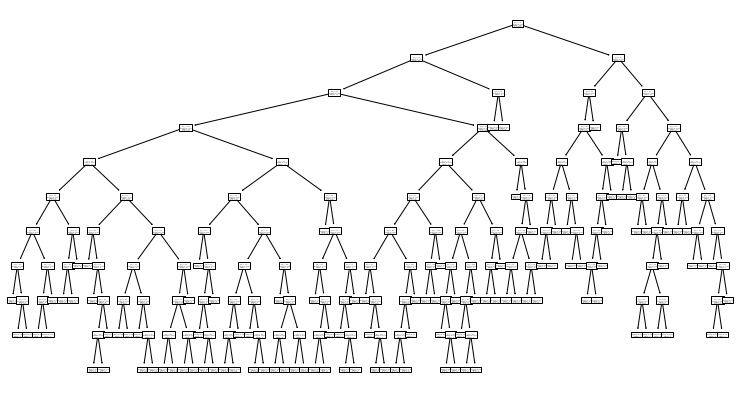

In [30]:
from sklearn import tree

# plot pruned tree of max_depth=10
features = ['Age', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
target = 'RiskLevelIndex'
dataset = data_changed.toPandas()[features+[target]]

# Regression tree on maternal data
fig = plt.figure(figsize=(13,7))
regr= tree.DecisionTreeRegressor(max_depth=10) 
regr.fit(dataset[features], dataset[target])
tree.plot_tree(regr)

In [31]:
# 8.2.5

In [33]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

In [34]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# measure model performance
rfc = RandomForestClassifier(labelCol='RiskLevelIndex',featuresCol='features_scaled', seed=4,
                            numTrees=20, maxDepth=10, maxBins=17, subsamplingRate=0.97)
model = rfc.fit(train_data)
# predict response
predictions = model.transform(test_data)
# BinaryClassificationEva.luator
evaluator = BinaryClassificationEvaluator(labelCol="RiskLevelIndex", rawPredictionCol="prediction", metricName='areaUnderROC')
# Make predicitons
predictionAndTarget = predictions.select("RiskLevelIndex", "prediction")
# measure area under curve
auc = evaluator.evaluate(predictionAndTarget)

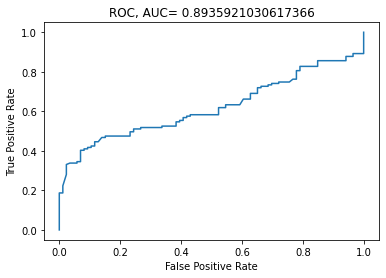

In [35]:
# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('RiskLevelIndex','probability').rdd.map(lambda row: (float(row['probability'][1]),
                                                                                float(row['RiskLevelIndex'])))
roc = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in roc]
y_val = [x[1] for x in roc]
plt.title('ROC, AUC= '+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(x_val, y_val)

In [36]:
from pyspark.mllib.evaluation import MulticlassMetrics
# Metrics
predictionRDD = predictions.select(['RiskLevelIndex', 'prediction']).rdd.map(lambda line: (line[1], line[0]))
metrics = MulticlassMetrics(predictionRDD)

# Confusion Matrix
print('Confusion Matrix \n', metrics.confusionMatrix().toArray())
print('\nAccuracy =', metrics.accuracy)

Confusion Matrix 
 [[71. 14.  1.]
 [13. 62.  3.]
 [ 1.  5. 55.]]

Accuracy = 0.8355555555555556


In [37]:
# 8.3

In [38]:
def parse_debug_string_lines(lines):
    
    block = []
    while lines:

        if lines[0].startswith('If'):
            bl = ' '.join(lines.pop(0).split()[1:]).replace('(', '').replace(')', '')
            block.append({'name': bl, 'children': parse_debug_string_lines(lines)})

            if lines[0].startswith('Else'):
                be = ' '.join(lines.pop(0).split()[1:]).replace('(', '').replace(')', '')
                block.append({'name': be, 'children': parse_debug_string_lines(lines)})
        elif not lines[0].startswith(('If', 'Else')):
            block2 = lines.pop(0)
            block.append({'name': block2})
        else:
            break
    
    return block

def debug_str_to_json(debug_string):
    data = []
    for line in debug_string.splitlines():
        if line.strip():
            line = line.strip()
            data.append(line)
        else:
            break
        if not line: break

    json = {'name': 'Root', 'children': parse_debug_string_lines(data[1:])}
    
    return json

In [39]:
# rfc model
rfc = RandomForestClassifier(labelCol='RiskLevelIndex',featuresCol='features_scaled', seed=4,
                            numTrees=20, maxDepth=10, maxBins=17, subsamplingRate=0.97)
# prepare data and model
pipeline = Pipeline(stages=[rfc])
model = pipeline.fit(data_changed)
tree_model_classifier = model.stages[0]

f_type_to_flist_dict = data_changed.schema['features'].metadata["ml_attr"]["attrs"]
f_index_to_name_dict = {}
for f_type, f_list in f_type_to_flist_dict.items():
   for f in f_list:
       f_index = f['idx']
       f_name = f['name']
       f_index_to_name_dict[f_index] = f_name

tree = tree_model_classifier.toDebugString
for i in range(len(f_index_to_name_dict)):
   tree = tree.replace('feature {}'.format(i), f_index_to_name_dict.get(i))

debug_str_to_json(tree)

{'name': 'Root',
 'children': [{'name': 'Tree 0 (weight 1.0):'},
  {'name': 'BS <= 2.5827513666338042',
   'children': [{'name': 'DiastolicBP <= 7.015647606423727',
     'children': [{'name': 'BodyTemp <= 72.37315033735982',
       'children': [{'name': 'DiastolicBP <= 3.5617903232612766',
         'children': [{'name': 'Predict: 0.0'}]},
        {'name': 'DiastolicBP > 3.5617903232612766',
         'children': [{'name': 'Age <= 1.0773563138523257',
           'children': [{'name': 'BS <= 2.081393748404889',
             'children': [{'name': 'Predict: 1.0'}]},
            {'name': 'BS > 2.081393748404889',
             'children': [{'name': 'Predict: 0.0'}]}]},
          {'name': 'Age > 1.0773563138523257',
           'children': [{'name': 'BS <= 2.1284909792082116',
             'children': [{'name': 'DiastolicBP <= 5.936317205435461',
               'children': [{'name': 'DiastolicBP <= 4.785031444381311',
                 'children': [{'name': 'Age <= 1.3745580556046912',
         

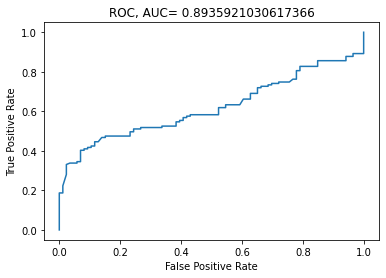

In [40]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# measure model performance
rfc = RandomForestClassifier(labelCol='RiskLevelIndex',featuresCol='features_scaled', seed=4,
                            numTrees=20, maxDepth=10, maxBins=17, subsamplingRate=0.97)
model = rfc.fit(train_data)
# predict response
predictions = model.transform(test_data)
# BinaryClassificationEva.luator
evaluator = BinaryClassificationEvaluator(labelCol="RiskLevelIndex", rawPredictionCol="prediction", metricName='areaUnderROC')
# Make predicitons
predictionAndTarget = predictions.select("RiskLevelIndex", "prediction")
# measure area under curve
auc = evaluator.evaluate(predictionAndTarget)
# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('RiskLevelIndex','probability').rdd.map(lambda row: (float(row['probability'][1]),
                                                                                float(row['RiskLevelIndex'])))
roc = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in roc]
y_val = [x[1] for x in roc]
plt.title('ROC, AUC= '+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(x_val, y_val)

In [41]:
predictions.select('RiskLevelIndex').toPandas().value_counts()/predictions.count()

RiskLevelIndex
0.0               0.382222
1.0               0.346667
2.0               0.271111
dtype: float64

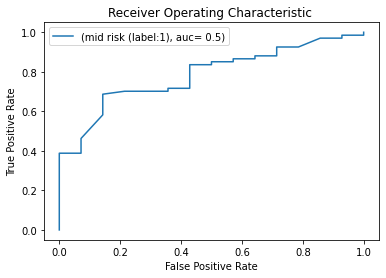

In [42]:
# Make predicitons
predictionAndTarget = predictions.select("RiskLevelIndex", "prediction").where(predictions.prediction==1)
# measure area under curve
auc = evaluator.evaluate(predictionAndTarget)
# Returns as a list (false positive rate, true positive rate)
prediction1=predictions.select('RiskLevelIndex','probability').where(predictions.prediction==1)
preds = prediction1.rdd.map(lambda row: (float(row['probability'][1]), float(row['RiskLevelIndex'])))
roc = CurveMetrics(preds).get_curve('roc')
x_val = [x[0] for x in roc]
y_val = [x[1] for x in roc]
plt.plot(x_val, y_val, label=f"(mid risk (label:1), auc= {auc})")
    
plt.title('Receiver Operating Characteristic ')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

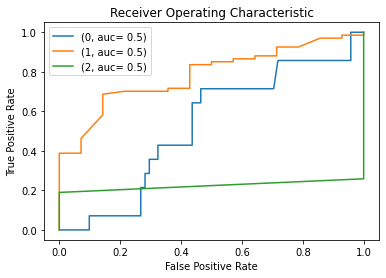

In [43]:
# receiver operating characterics for "high risk"
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# measure model performance
rfc = RandomForestClassifier(labelCol='RiskLevelIndex',featuresCol='features_scaled', seed=4,
                            numTrees=20, maxDepth=10, maxBins=17, subsamplingRate=0.97)
model = rfc.fit(train_data)
# predict response
predictions = model.transform(test_data)
# BinaryClassificationEva.luator
evaluator = BinaryClassificationEvaluator(labelCol="RiskLevelIndex", rawPredictionCol="prediction", metricName='areaUnderROC')
# Make predicitons
predictionAndTarget = predictions.select("RiskLevelIndex", "prediction").where(predictions.prediction==0.0)
# measure area under curve
auc = evaluator.evaluate(predictionAndTarget)

plt.figure()
for i in range(0,3):
    # Make predicitons
    predictionAndTarget = predictions.select("RiskLevelIndex", "prediction").where(predictions.prediction==i)
    # measure area under curve
    auc = evaluator.evaluate(predictionAndTarget)
    # Returns as a list (false positive rate, true positive rate)
    prediction1=predictions.select('RiskLevelIndex','probability').where(predictions.prediction==i)
    preds = prediction1.rdd.map(lambda row: (float(row['probability'][1]), float(row['RiskLevelIndex'])))
    roc = CurveMetrics(preds).get_curve('roc')
    x_val = [x[0] for x in roc]
    y_val = [x[1] for x in roc]
    plt.plot(x_val, y_val, label=f"({i}, auc= {auc})")
    
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

In [44]:
# 8.4

In [46]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# measure model performance
rfc = RandomForestClassifier(labelCol='RiskLevelIndex',featuresCol='features_scaled', seed=4,
                            numTrees=20, maxDepth=10, maxBins=17, subsamplingRate=0.97)
model = rfc.fit(train_data)
# predict response
predictions = model.transform(test_data)
# Metrics
predictionRDD = predictions.select(['RiskLevelIndex', 'prediction']).rdd.map(lambda line: (line[1], line[0]))
metrics = MulticlassMetrics(predictionRDD)
# Confusion Matrix
print('Confusion Matrix \n', metrics.confusionMatrix().toArray())
print('\nAccuracy =', metrics.accuracy)

Confusion Matrix 
 [[71. 14.  1.]
 [13. 62.  3.]
 [ 1.  5. 55.]]

Accuracy = 0.8355555555555556


In [49]:
# correlation in between features 'SystolicBP' and 'DiastolicBP'
data.select('SystolicBP', 'DiastolicBP').toPandas().corr()

,SystolicBP,DiastolicBP
SystolicBP,1.000000,0.786854
DiastolicBP,0.786854,1.000000


In [54]:
# calculate performance accuracy on all the features
data_changed=data.select(data.columns[0:8])
data_changed = data_changed.drop('SystolicBP')
# collect the input features
assembler = VectorAssembler(
        inputCols=['Age','DiastolicBP','BS','BodyTemp','HeartRate'], outputCol="features")
# transform the data
data_changed=assembler.transform(data_changed)
# standardize the feature values
standardScaler=StandardScaler()
standardScaler.setInputCol('features')
model=standardScaler.fit(data_changed)
model.setOutputCol('features_scaled')
data_changed=model.transform(data_changed)

In [55]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# splitting data into training and test data set
train_data, test_data = data_changed.randomSplit(weights=[0.75,0.25], seed=1)
# measure model performance
rfc = RandomForestClassifier(labelCol='RiskLevelIndex',featuresCol='features_scaled', seed=4,
                            numTrees=20, maxDepth=10, maxBins=17, subsamplingRate=0.97)
model = rfc.fit(train_data)
# predict response
predictions = model.transform(test_data)
# Metrics
predictionRDD = predictions.select(['RiskLevelIndex', 'prediction']).rdd.map(lambda line: (line[1], line[0]))
metrics = MulticlassMetrics(predictionRDD)
# Confusion Matrix
print('Confusion Matrix \n', metrics.confusionMatrix().toArray())
print('\nAccuracy =', metrics.accuracy)

Confusion Matrix 
 [[71. 14.  1.]
 [13. 62.  3.]
 [ 1.  5. 55.]]

Accuracy = 0.8355555555555556


In [59]:
from pyspark.ml import Pipeline
# prepare data and model
pipeline = Pipeline(stages=[rfc])
model = pipeline.fit(data_changed)
tree_model_classifier = model.stages[0]
print(tree_model_classifier.toDebugString)

RandomForestClassificationModel: uid=RandomForestClassifier_212af219cef2, numTrees=20, numClasses=3, numFeatures=5
  Tree 0 (weight 1.0):
    If (feature 2 <= 2.5827513666338042)
     If (feature 1 <= 7.015647606423727)
      If (feature 3 <= 72.37315033735982)
       If (feature 1 <= 3.5617903232612766)
        Predict: 0.0
       Else (feature 1 > 3.5617903232612766)
        If (feature 0 <= 1.0773563138523257)
         If (feature 2 <= 2.081393748404889)
          Predict: 1.0
         Else (feature 2 > 2.081393748404889)
          Predict: 0.0
        Else (feature 0 > 1.0773563138523257)
         If (feature 2 <= 2.1284909792082116)
          If (feature 1 <= 5.936317205435461)
           If (feature 1 <= 4.785031444381311)
            If (feature 0 <= 1.3745580556046912)
             If (feature 1 <= 3.957544803623641)
              Predict: 1.0
             Else (feature 1 > 3.957544803623641)
              Predict: 0.0
            Else (feature 0 > 1.3745580556046912)
         

In [79]:
# splitting data into training and test data set
train_data, test_data = data_changed.randomSplit(weights=[0.75,0.25], seed=1)
# measure model performance
rfc = RandomForestClassifier(labelCol='RiskLevelIndex',featuresCol='features_scaled', seed=4,
                            numTrees=20, maxDepth=10, maxBins=17, subsamplingRate=0.97)
model = rfc.fit(train_data)

In [80]:
# predict 'RiskLevelIndex' from raw data
from pyspark.ml.linalg import Vectors
model.predict(Vectors.dense([35, 80, 8, 70, 60]))

2.0